In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm
from itertools import cycle
from random import shuffle
from sklearn.model_selection import train_test_split



import torch
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import OrderedDict

from cycle_consistent_vae_in import Encoder, Decoder

np.random.bit_generator = np.random._bit_generator

In [2]:
cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

MODEL_PATH = "./models/cycle_vae_512_64_in_13052020-175056_499.pth"
checkpoint = torch.load(MODEL_PATH)

Z_DIM = 512 #Style Dimension (Unspecified)
S_DIM = 64 # Class Dimension (Specified)

encoder = Encoder(style_dim=Z_DIM, class_dim=S_DIM)
encoder.load_state_dict(checkpoint['encoder'])

encoder.to(device)
# encoder.eval()

Encoder(
  (conv_model): Sequential(
    (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_1): ReLU(inplace)
    (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_2): ReLU(inplace)
    (conv_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_3): ReLU(inplace)
    (conv_4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (relu_4): ReLU(inplace)
  )
  (style_mu): Linear(in_features=512, out_features=512, bias=True)
  (style_logvar): Linear(in_features=512, out_features=512, bias=True)
  (c

In [3]:
decoder = Decoder(style_dim=Z_DIM, class_dim=S_DIM)
decoder.load_state_dict(checkpoint['decoder'])

decoder.to(device)
# encoder.eval()

Decoder(
  (style_input): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (class_input): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (deconv_model): Sequential(
    (deconv_1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_1): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_2): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_3): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (leakyrelu_3): LeakyReLU(negative

# Data Processing

In [4]:
def reparameterize(training, mu, logvar):
    if training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    else:
        return mu

In [5]:
class Latent(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][:,:,:3]
        
        return (img, self.labels[index])

In [6]:
t1 = pickle.load(open('train_latent.pkl','rb'))
t2 = pickle.load(open('test_latent.pkl','rb'))

In [7]:
BATCH_SIZE = 16
train_loader = DataLoader(t1,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
test_loader = DataLoader(t2,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [8]:
class UnspecToSpecClassifier(nn.Module):
    def __init__(self, style_dim, class_dim):
        super(UnspecToSpecClassifier, self).__init__()

        self.fc_model = nn.Sequential(OrderedDict([
            ('fc_1', nn.Linear(in_features=style_dim, out_features=256, bias=True)),
#             ('fc_1_bn', nn.BatchNorm1d(num_features=2048)),
            ('leakyrelu_1', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('fc_2', nn.Linear(in_features=256, out_features=128, bias=True)),
#             ('fc_2_bn', nn.BatchNorm1d(num_features=1024)),
            ('leakyrelu_2', nn.LeakyReLU(negative_slope=0.2, inplace=True)),

            ('fc_3', nn.Linear(in_features=128, out_features=class_dim, bias=True))
        ]))

    def forward(self, z):
        x = self.fc_model(z)
        return x

# Training Classifiers

## Input as unspecified partition and output as specified partition

In [ ]:
TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

NUM_EPOCHS = 200

LEARNING_RATE = 1e-3

MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
CUDA = True

In [ ]:
model = UnspecToSpecClassifier(style_dim=Z_DIM, class_dim=S_DIM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
is_better = True
prev_acc = float('inf')
name = "unspec_to_spec_512_64"

liveloss = PlotLosses(fig_path='./figures/'+name+".png")

In [ ]:
dataloaders = {'train':train_loader, 'validation':test_loader}

In [ ]:
for epoch in range(NUM_EPOCHS):
    logs = {}
    t_start = time.time()
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
        model.to(device)
        
        print("Started Phase")

        running_loss = 0.0
                
        if phase == 'validation':
            
            with torch.no_grad():
                
                for (i,batch) in enumerate(dataloaders[phase]):
                    input_tensor = batch[0]
                    input_tensor = input_tensor.to(device)
                    input_tensor = torch.transpose(input_tensor, 2,3)
                    input_tensor = torch.transpose(input_tensor, 1,2)

                    mu, logvar, s = encoder(input_tensor)
                    z = reparameterize(False, mu, logvar)

                    bs = input_tensor.shape[0]
                    target_tensor = batch[1].to(device).reshape(bs)

                    softmaxed_tensor = model(z)

                    loss = criterion(softmaxed_tensor, s.float())

                    input_tensor = input_tensor.cpu()

                    running_loss += loss.detach() * bs
                
     
        else:
            
            for (i,batch) in enumerate(dataloaders[phase]):
                with torch.no_grad():
                    input_tensor = batch[0]
                    input_tensor = input_tensor.to(device)
                    input_tensor = torch.transpose(input_tensor, 2,3)
                    input_tensor = torch.transpose(input_tensor, 1,2)

                    mu, logvar, s = encoder(input_tensor)
                    z = reparameterize(False, mu, logvar)

                bs = input_tensor.shape[0]
                target_tensor = batch[1].to(device).reshape(bs)

                softmaxed_tensor = model(z)

                loss = criterion(softmaxed_tensor, s.float())

                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                input_tensor = input_tensor.cpu()

                running_loss += loss.detach() * bs
    

        epoch_loss = running_loss / len(dataloaders[phase].dataset)

        
        model.to('cpu')

        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        
        print('Phase time - ',time.time() - t_start)

    delta = time.time() - t_start
    is_better = logs['val_log loss'] < prev_acc
    if is_better:
        prev_acc = logs['val_log loss']
        torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'loss': logs['log loss']}, "./models/"+name+"_"+TIME_STAMP+"_"+str(logs['val_log loss'])+".pth")


    liveloss.update(logs)
    liveloss.draw()

# Analysis

To plot a batch of original images, along with the one obtained using the prediction network

In [9]:
def imshow_grid(images, shape=[2, 8], name='default', save=False):
    """
    Plot images in a grid of a given shape.
    Initial code from: https://github.com/pumpikano/tf-dann/blob/master/utils.py
    """
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    if save:
        plt.savefig('./figures/' + str(name) + '.png')
        plt.clf()
    else:
        plt.show()

In [10]:
test_loader = cycle(test_loader)

In [11]:
SPECIFIED_MODEL_PATH = './models/unspec_to_spec_512_64_15052020-005114_0.0991375595331192.pth'
checkpoint = torch.load(SPECIFIED_MODEL_PATH)

criterion = torch.nn.MSELoss()

model = UnspecToSpecClassifier(style_dim=Z_DIM, class_dim=S_DIM)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

UnspecToSpecClassifier(
  (fc_model): Sequential(
    (fc_1): Linear(in_features=512, out_features=256, bias=True)
    (leakyrelu_1): LeakyReLU(negative_slope=0.2, inplace)
    (fc_2): Linear(in_features=256, out_features=128, bias=True)
    (leakyrelu_2): LeakyReLU(negative_slope=0.2, inplace)
    (fc_3): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [12]:
elem1 = next(test_loader)
image_batch_1 = elem1[0].to(device)
image_batch_1 = torch.transpose(image_batch_1, 2,3)
image_batch_1 = torch.transpose(image_batch_1, 1,2)


z_mu_1, z_logvar_1, _ = encoder(image_batch_1)
z_1 = reparameterize(training=False, mu=z_mu_1, logvar=z_logvar_1)

with torch.no_grad():
    s_1 = model(z_1)
    recons = decoder(z_1, s_1)

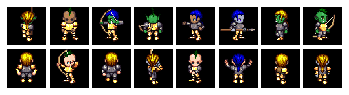

In [13]:
imshow_grid(np.transpose(image_batch_1.detach().cpu().numpy(), (0, 2, 3, 1)),\
            name='_target', save=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

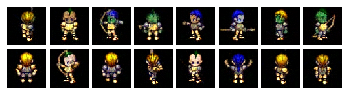

In [14]:
imshow_grid(np.transpose(recons.detach().cpu().numpy(), (0, 2, 3, 1)),\
            name='_target', save=False)